In [421]:
import keras
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from pylab import imread, imshow
from skimage.color import rgb2gray
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

In [73]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        # second layer
        x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
        padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    return x

In [ ]:
def get_unet(dropout, input_img):
    inputs = input_img
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(inputs)
    conv1 = Dropout(dropout)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool1)
    conv2 = Dropout(dropout)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(pool2)
    conv3 = Dropout(dropout)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv3)

    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = concatenate([conv2,up1],axis=1)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(up1)
    conv4 = Dropout(dropout)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv4)
    #
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = concatenate([conv1,up2], axis=1)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(up2)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',data_format='channels_first')(conv5)
    #
    conv6 = Conv2D(2, (1, 1), activation='relu',padding='same',data_format='channels_first')(conv5)
    conv6 = core.Reshape((2,patch_height*patch_width))(conv6)
    conv6 = core.Permute((2,1))(conv6)
    ############
    conv7 = core.Activation('softmax')(conv6)

    model = Model(inputs=inputs, outputs=conv7)
    return model

In [534]:
def load_images_from_folder(folder_path):
    file_names = os.listdir(folder_path)
    file_names.sort()
    images = []
    for filename in file_names:
        try:
            image =imread(folder_path + filename)
            images.append(rgb2gray(image).reshape(32,32,1))
        except:
            continue
    return images

In [531]:
def generator(x_train, y_train, batch_size):
    data_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True, validation_split=0.2,
    ).flow(x_train, x_train, batch_size, seed=1)
    mask_gen = ImageDataGenerator(
        horizontal_flip = True, vertical_flip = True
    ).flow(y_train, y_train, batch_size, seed=1)
    while True:
        x_batch, _ = data_gen.next()
        y_batch, _ = mask_gen.next()
        yield x_batch, y_batch

## Test data augmentation function

failed:  ../../data/DRIVE/training/patches/ .DS_Store
1910
failed:  ../../data/DRIVE/training/patchLabels/ .DS_Store
1910


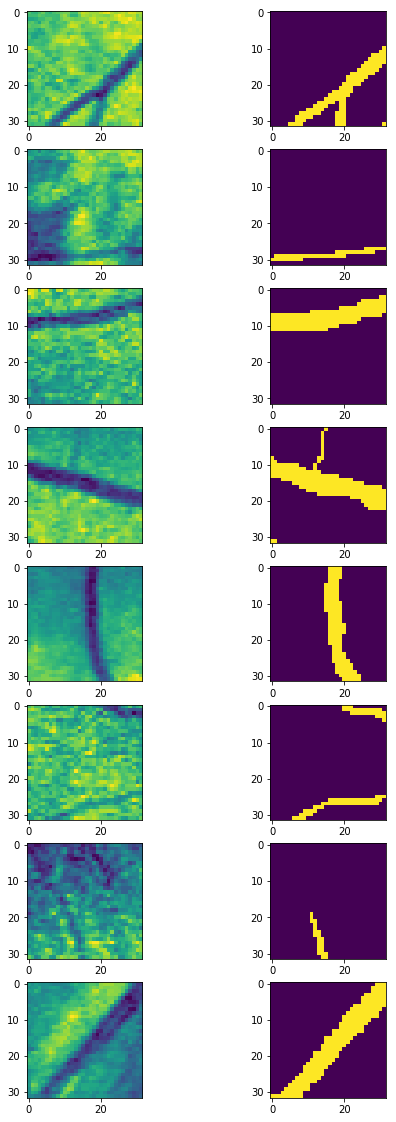

In [535]:

X_train = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
y_train = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
image_batch, mask_batch = next(generator(X_train, y_train, 8))
fix, ax = plt.subplots(8,2, figsize=(8,20))
for i in range(8):
    ax[i,0].imshow(image_batch[i,:,:,0])
    ax[i,1].imshow(mask_batch[i,:,:,0])
plt.show()

In [526]:
def train(epochs):
    X_train = np.array(load_images_from_folder("../../data/DRIVE/training/patches/"))
    y_train = np.array(load_images_from_folder("../../data/DRIVE/training/patchLabels/"))
    input_img = Input((32,32,1))
    model = get_unet(n_filters = 16, dropout = 0.05, input_img = input_img)
    opt  = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    model.summary()
    batch_size = 32    
    history = model.fit_generator(generator(X_train, y_train, batch_size = 32),
                              epochs = epochs, steps_per_epoch = len(X_train)//32)
    return model, history
    

In [522]:
res, history = train(70)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_50 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_788 (Conv2D)             (None, 32, 32, 16)   160         input_50[0][0]                   
__________________________________________________________________________________________________
batch_normalization_749 (BatchN (None, 32, 32, 16)   64          conv2d_788[0][0]                 
__________________________________________________________________________________________________
activation_749 (Activation)     (None, 32, 32, 16)   0           batch_normalization_749[0][0]    
__________________________________________________________________________________________________
conv2d_789

Epoch 1/70
59/59 [==============================] - 42s 708ms/step - loss: 0.5750
Epoch 2/70
59/59 [==============================] - 19s 325ms/step - loss: 0.5259
Epoch 3/70
59/59 [==============================] - 19s 323ms/step - loss: 0.4978
Epoch 4/70
59/59 [==============================] - 19s 325ms/step - loss: 0.4695
Epoch 5/70
59/59 [==============================] - 19s 324ms/step - loss: 0.4448
Epoch 6/70
59/59 [==============================] - 19s 324ms/step - loss: 0.4311
Epoch 7/70
59/59 [==============================] - 19s 325ms/step - loss: 0.4217
Epoch 8/70
59/59 [==============================] - 19s 326ms/step - loss: 0.4142
Epoch 9/70
59/59 [==============================] - 19s 326ms/step - loss: 0.4103
Epoch 10/70
59/59 [==============================] - 19s 326ms/step - loss: 0.4030
Epoch 11/70
59/59 [==============================] - 19s 325ms/step - loss: 0.4015
Epoch 12/70
59/59 [==============================] - 19s 326ms/step - loss: 0.3984
Epoch 13/70
5

dict_keys(['loss'])


KeyError: 'val_loss'

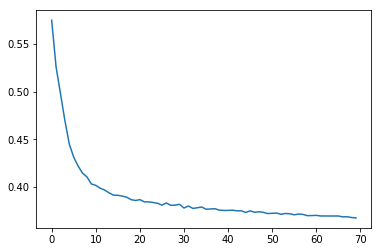

In [523]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()


In [527]:
print(len(X_train))

1910


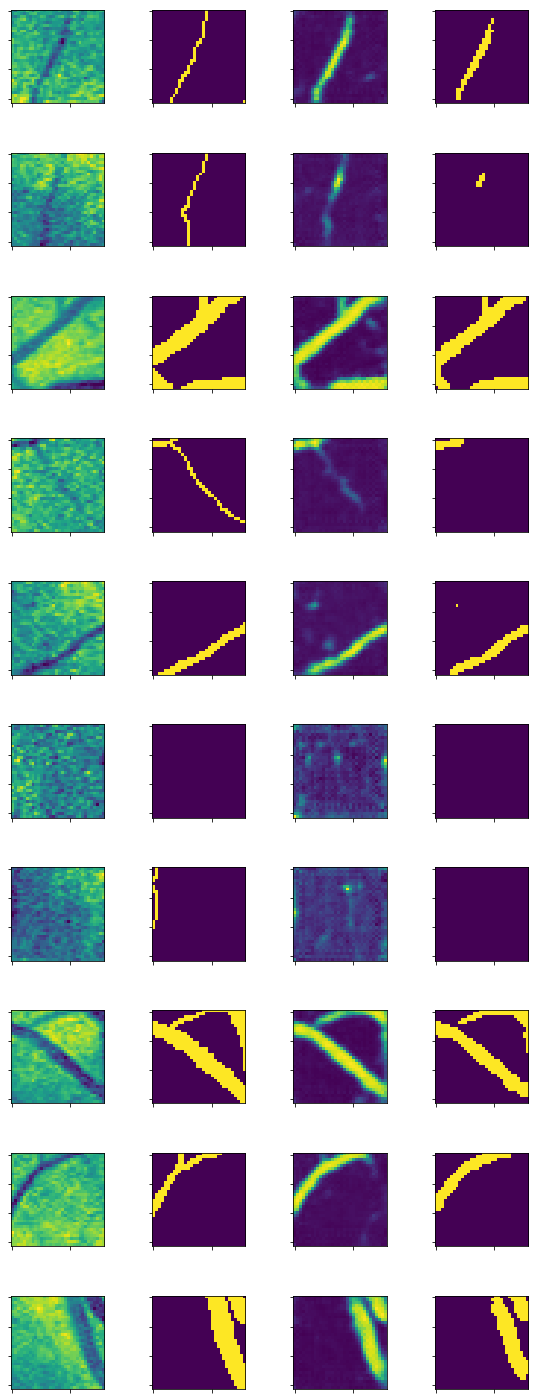

In [525]:
nr_of_images = 10
fig, ax = plt.subplots(nr_of_images,4, figsize=(8,20))
fig.tight_layout()
for image_nr in range(nr_of_images):
    ax[image_nr,0].imshow(X_train[image_nr].reshape(32,32))
    ax[image_nr,1].imshow(y_train[image_nr].reshape(32,32))
    y_pred = res.predict(X_train[image_nr:(image_nr+1)]).reshape(32,32)
    y_pred_thr = y_pred.copy()
    y_pred_thr[y_pred > 0.5] = 1
    y_pred_thr[y_pred <= 0.5] = 0
    ax[image_nr,2].imshow(y_pred)
    ax[image_nr,3].imshow(y_pred_thr)
    for j in range(4):
        ax[image_nr,j].set_xticklabels([])
        ax[image_nr,j].set_yticklabels([])
plt.show()